## Four Corner Shell Bending Example

In [1]:
import numpy as np

import dismech

geom = dismech.GeomParams(rod_r0=0,
                          shell_h=1e-3)

material = dismech.Material(density=1200,
                            youngs_rod=0,
                            youngs_shell=2e8,  # stainless steel
                            poisson_rod=0,
                            poisson_shell=0.5)

static_3d_sim = dismech.SimParams(static_sim=True,
                                  two_d_sim=False,
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-2,
                                  max_iter=25,
                                  total_time=1e-2,
                                  plot_step=10,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))

geo = dismech.Geometry.from_txt('three_corner.txt')

robot = dismech.SoftRobot(geom, material, geo, static_3d_sim, env)

### Energy

In [2]:
# set strain_bar
stretch_energy = dismech.StretchEnergy(robot.stretch_springs, robot.state)

### Static Simulation

In [3]:
robot = robot.fix_nodes([0,1])
robot = robot.fix_nodes([2], 0) # fix z axis
stepper = dismech.ImplicitEulerTimeStepper(robot)
robots = stepper.simulate()
qs = np.stack([robot.state.q for robot in robots])

# Static Sim = 1 output
robot_eq = robots[-1]
q_eq = robots[-1].state.q

  0%|          | 0/1 [00:00<?, ?it/s]

### Visualization

In [4]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)  # (100)
options = dismech.AnimationOptions(z_lim=[-1.0, 1.0], x_lim=[0, 1.0], title='Four Corners')
fig = dismech.get_interactive_animation_plotly(robot, t, np.array([q_eq]), options)
fig.show()

In [5]:
# Very slight deviation
print(robot.state.q)
print(robot_eq.state.q)

[0. 0. 0. 0. 1. 0. 1. 0. 1.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  1.00000000e+00 -3.20393258e-05
  9.99967961e-01]


### Energy

In [6]:
print("Stretch Energy: {}".format(stretch_energy.get_energy_linear_elastic(robot_eq.state)))

Stretch Energy: 4.444741441403827e-05


## Sample Manipulation Calculation

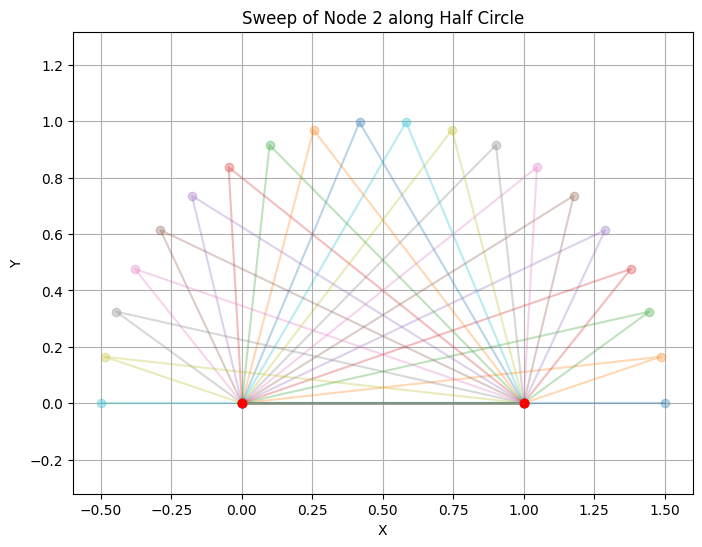

In [7]:
import matplotlib.pyplot as plt

# GPT
def sweep_node(radius=1.0, num_steps=20, z_height=0.0):
    """
    Sweep the third node around a half-circle in the XY plane.

    Args:
        radius (float): Distance from the center of the circle.
        num_steps (int): Number of steps to sample along the half-circle.
        z_height (float): Z-coordinate for the third node (for 3D positioning).

    Returns:
        List of node positions: [[(x0, y0, z0), (x1, y1, z1), (x2, y2, z2)], ...]
    """
    nodes_list = []

    # Fixed nodes
    node0 = np.array([0.0, 0.0, 0.0])
    node1 = np.array([1.0, 0.0, 0.0])

    # Center of the half-circle: midway between node0 and node1
    center = np.array([0.5, 0.0])

    # Sweep angles from 0 to pi (half circle)
    angles = np.linspace(0, np.pi, num_steps)

    for theta in angles:
        x = center[0] + radius * np.cos(theta)
        y = center[1] + radius * np.sin(theta)
        z = z_height  # You can vary this if you want 3D motion!

        node2 = np.array([x, y, z])

        # Append the triangle nodes
        nodes_list.append([node0, node1, node2])

    return nodes_list

def plot_sweep(nodes_list):
    plt.figure(figsize=(8, 6))
    for nodes in nodes_list:
        node0, node1, node2 = nodes
        x = [node0[0], node1[0], node2[0], node0[0]]
        y = [node0[1], node1[1], node2[1], node0[1]]
        plt.plot(x, y, 'o-', alpha=0.3)

    plt.plot([0.0, 1.0], [0.0, 0.0], 'ro')  # fixed nodes
    plt.title('Sweep of Node 2 along Half Circle')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Example usage:
nodes_list = sweep_node(radius=1.0, num_steps=20, z_height=0.0)
plot_sweep(nodes_list)

In [8]:
# Create a robot with all fixed nodes (w/o gravity)
coplaner_geo = dismech.Geometry.from_txt('three_corner_coplaner.txt')   # can be coplaner for energy
base_robot = dismech.SoftRobot(geom, material, coplaner_geo, static_3d_sim, dismech.Environment())
base_robot = base_robot.fix_nodes([0,1,2,3])
stretch_energy = dismech.StretchEnergy(base_robot.stretch_springs, base_robot.state)

robots = []
se = []

# For each position, displace the node and evaluate the hinge and stretching energy
for _, _, pos in nodes_list:
    disp_robot = base_robot.move_nodes([2], pos - np.array([0.5, 0.5, 0]))
    robots.append(disp_robot)
    se.append(stretch_energy.get_energy_linear_elastic(disp_robot.state))

qs = np.stack([robot.state.q for robot in robots])

### Visualization

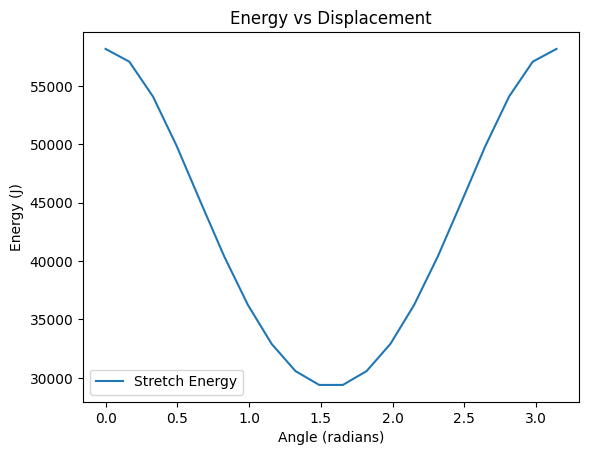

In [9]:
plt.plot(np.linspace(0, np.pi, 20), se, label='Stretch Energy')
plt.title('Energy vs Displacement')
plt.ylabel('Energy (J)')
plt.xlabel('Angle (radians)')
plt.legend()
plt.show()

In [10]:
options = dismech.AnimationOptions(z_lim=[-1.0, 1.0], title='Three Corners')
fig = dismech.get_interactive_animation_plotly(base_robot, np.arange(len(nodes_list)), qs, options)
fig.show()